# Features

In [76]:
import pandas as pd
import numpy as np
import glob
from sklearn.ensemble import GradientBoostingClassifier

# Load all point_visual csvs
file_paths = glob.glob("../data/match-csvs/point-visuals/*.csv")
df_list = [pd.read_csv(file) for file in file_paths]
data = pd.concat(df_list, ignore_index=True)

# Server binary indicator
data['server_is_player1'] = (data['serverName'] == data['player1Name']).astype(int)

# Convert pointScore to 0-3 & flip when server is not player1
point_map = {0: 0, 15: 1, 30: 2, 40: 3}
data['player1PointScore'] = data['player1PointScore'].map(point_map)
data['player2PointScore'] = data['player2PointScore'].map(point_map)
data.loc[(data['server_is_player1'] == 0), ['player1PointScore', 'player2PointScore']] = data.loc[(data['server_is_player1'] == 0), ['player2PointScore', 'player1PointScore']].values


data['rallyCount'] = pd.to_numeric(data['rallyCount'], errors='coerce').fillna(0)
data['is_break_point'] = data['isBreakPoint'].astype(int)

# Target
data['point_won'] = (data['pointWonBy'] == data['player1Name']).astype(int)

# Features for WP model
features = ['player1SetScore','player2SetScore', 
            'player1GameScore','player2GameScore',
            'player1PointScore','player2PointScore',
            'is_break_point', 
            'server_is_player1']


# Win Probability Model (in player1's pov)

In [81]:
test = (data['player1Name'] == 'Rudy Quan') & (data['player2Name'] == 'Edward Winter')

train_dataset = data[~test].copy()
test_dataset = data[test].copy()

In [82]:
import xgboost as xgb
from xgboost import XGBClassifier
X_train = train_dataset[features]
y_train = train_dataset['point_won']

wp_model = XGBClassifier(learning_rate=0.01, 
                         max_depth=3, 
                         min_child_weight=5, 
                         n_estimators=200, 
                         subsample=1.0, 
                         colsample_bytree=1.0, 
                         random_state=42)
wp_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

### Picking Model

In [38]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

X = data[features]
y = data['point_won']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_model = XGBClassifier(
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))



Fitting 5 folds for each of 972 candidates, totalling 4860 fits


KeyboardInterrupt: 

# Leverage Index Model

TBD: Need to speed up model -- parallelize

In [83]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def simulate_match_from_state(model, state, features, n_sims, max_points=200):
    wins = 0
    cache = {}

    for _ in range(n_sims):
        s = state.copy()
        p1_sets, p2_sets = s['player1SetScore'], s['player2SetScore']
        p1_games, p2_games = s['player1GameScore'], s['player2GameScore']
        p1_pts, p2_pts = s['player1PointScore'], s['player2PointScore']
        server = s['server_is_player1']
        break_point = s['is_break_point']

        for _ in range(max_points):
            # Stops if match is won
            if (p1_sets == 2 or p2_sets == 2 and abs(p1_sets - p2_sets) == 2) or (p1_sets > 2 or p2_sets > 2):
                break

            # Cache key based on state
            key = (p1_sets, p2_sets, p1_games, p2_games, p1_pts, p2_pts, server)
            if key not in cache:
                df = pd.DataFrame([{
                    'player1SetScore': p1_sets,
                    'player2SetScore': p2_sets,
                    'player1GameScore': p1_games,
                    'player2GameScore': p2_games,
                    'player1PointScore': p1_pts,
                    'player2PointScore': p2_pts,
                    'is_break_point': break_point,
                    'server_is_player1': server
                }])
                cache[key] = model.predict_proba(df[features])[0, 1]
            p_point = cache[key]

            point_won = np.random.rand() < p_point

            # Update point score
            if point_won:
                p1_pts += 1
            else:
                p2_pts += 1

            # Updates game score, if necessary
            if p1_pts >= 4:
                p1_games += 1
                p1_pts = p2_pts = 0
                server = 1 - server
                break_point = 0
            elif p2_pts >= 4:
                p2_games += 1
                p1_pts = p2_pts = 0
                server = 1 - server
                break_point = 0
            elif (p1_pts == 3 and p2_pts < 3 and server == 1) or (p1_pts < 3 and p2_pts == 3 and server == 0):
                break_point = 1

            # Updates set score, if won
            if (p1_games >= 6 and p1_games - p2_games >= 2) or (p1_games > 6):
                p1_sets += 1
                p1_games = p2_games = 0
            elif (p2_games >= 6 and p2_games - p1_games >= 2) or (p2_games > 6):
                p2_sets += 1
                p1_games = p2_games = 0

        if p1_sets > p2_sets:
            wins += 1
    # Returns the probability of winning the match, based on simulated average
    return wins / n_sims


def sequential_match_simulator_player1_prior(df, wp_model, features, n_sims=50):
    match_wp_list = []
    leverage_list = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Simulating match probabilities"):
        base = {
            'player1SetScore': row['player1SetScore'],
            'player2SetScore': row['player2SetScore'],
            'player1GameScore': row['player1GameScore'],
            'player2GameScore': row['player2GameScore'],
            'player1PointScore': row['player1PointScore'],
            'player2PointScore': row['player2PointScore'],
            'is_break_point': row['is_break_point'],
            'server_is_player1': row['server_is_player1']
        }

        # If player1 wins next point
        win_feat = base.copy()
        win_feat['player1PointScore'] += 1
        if win_feat['player1PointScore'] > 3: 
            win_feat['player1PointScore'] = 0 
            win_feat['player2PointScore'] = 0 
            win_feat['player1GameScore'] += 1 
            if win_feat['player1GameScore'] > 6: 
                win_feat['player1GameScore'] = 0 
                win_feat['player2GameScore'] = 0 
                win_feat['player1SetScoreore'] += 1
        wp_after_win = simulate_match_from_state(wp_model, win_feat, features, n_sims=n_sims)

        # If player1 loses next point
        lose_feat = base.copy()
        lose_feat['player2PointScore'] += 1
        if lose_feat['player2PointScore'] > 3: 
            lose_feat['player1PointScore'] = 0 
            lose_feat['player2PointScore'] = 0 
            lose_feat['player2GameScore'] += 1 
            if lose_feat['player2GameScore'] > 6: 
                lose_feat['player1GameScore'] = 0 
                lose_feat['player2GameScore'] = 0 
                lose_feat['player2SetScore'] += 1
        wp_after_loss = simulate_match_from_state(wp_model, lose_feat, features, n_sims=n_sims)

        # Win probability of base state
        match_wp = simulate_match_from_state(wp_model, base.copy(), features, n_sims=n_sims)
        match_wp_list.append(match_wp)

        # Calculates Leverage
        denom = match_wp * (1-match_wp) if 0 < match_wp < 1 else 1
        leverage = abs(wp_after_win - wp_after_loss) / denom
        leverage_list.append(leverage)

    df['match_wp_player1'] = match_wp_list
    df['match_leverage_player1'] = leverage_list
    return df


In [84]:
data = sequential_match_simulator_player1_prior(test_dataset, wp_model, features)

Simulating match probabilities: 100%|██████████| 144/144 [56:45<00:00, 23.65s/it] 


## Check Results

In [158]:
data[['Name', 'is_break_point', 'match_wp_player1', 'match_leverage_player1']].head(15)

,Name,is_break_point,match_wp_player1,match_leverage_player1
188,"Set 1: 0-0, 0-0 Edward Winter Serving",0,0.28,0.694444
189,"Set 1: 0-0, 15-0 Edward Winter Serving",0,0.18,0.271003
190,"Set 1: 0-0, 30-0 Edward Winter Serving",0,0.22,1.048951
191,"Set 1: 0-0, 40-0 Edward Winter Serving",0,0.16,0.148810
192,"Set 1: 0-1, 0-0 Rudy Quan Serving",0,0.10,0.222222
193,"Set 1: 0-1, 15-0 Rudy Quan Serving",0,0.20,0.125000
194,"Set 1: 0-1, 15-15 Rudy Quan Serving",0,0.12,0.378788
195,"Set 1: 0-1, 30-15 Rudy Quan Serving",0,0.16,0.446429
196,"Set 1: 0-1, 30-30 Rudy Quan Serving",0,0.16,0.446429
197,"Set 1: 0-1, 40-30 Rudy Quan Serving",0,0.08,0.271739


In [ ]:
# Some of these leverages are interesting, e.g. point 320 w/ leverage of 6.12 but at game score 0-0
    # may need to redefine leverage scaling / metric
    # may also need to increase # simulation once job is parallelized
data.loc[data['match_leverage_player1'] > 2, ['Name', 'match_wp_player1', 'match_leverage_player1']]

,Name,match_wp_player1,match_leverage_player1
208,"Set 1: 1-2, 30-15 Rudy Quan Serving",0.04,2.604167
210,"Set 1: 1-2, 30-40 Rudy Quan Serving",0.04,2.604167
211,"Set 1: 1-2, 40-40 Rudy Quan Serving",0.06,2.482270
230,"Set 1: 3-4, 30-15 Rudy Quan Serving",0.02,2.040816
250,"Set 2: 0-0, 40-30 Edward Winter Serving",0.68,2.297794
285,"Set 3: 0-0, 15-0 Edward Winter Serving",0.08,3.260870
289,"Set 3: 0-0, 40-30 Edward Winter Serving",0.06,2.127660
306,"Set 3: 0-3, 40-15 Rudy Quan Serving",0.02,4.081633
311,"Set 3: 1-3, 30-30 Edward Winter Serving",0.02,2.040816
318,"Set 3: 1-4, 40-30 Rudy Quan Serving",0.02,2.040816


### Check for any unusual WP

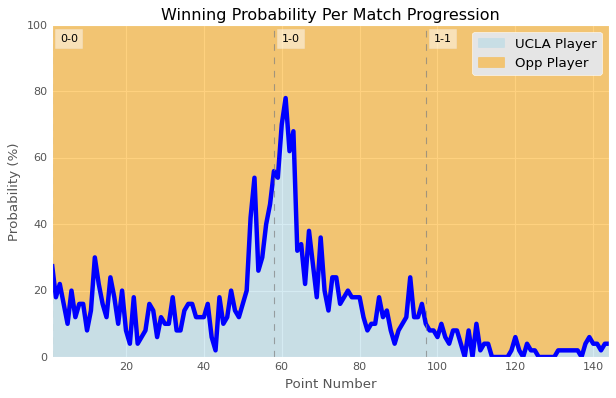

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
x = data['pointNumber']
y = data['match_wp_player1'] * 100
data['set_score'] = data['player1SetScore'].astype(str) + '-' + data['player2SetScore'].astype(str)
set_score_changes = data[data['set_score'].ne(data['set_score'].shift())]

plt.style.use('ggplot')
plt.figure(figsize=(8, 5))

plt.plot(x, y, color='blue')
plt.fill_between(x, y, 0, color='lightblue', alpha=0.5, label = 'UCLA Player')
plt.fill_between(x, y, 100, color='orange', alpha=0.5, label = "Opp Player")

for idx, row in set_score_changes.iterrows():
    plt.text(row['pointNumber'] + 2, 95, row['set_score'], fontsize=10, color='black', 
             bbox=dict(facecolor='white', alpha=0.5))
    plt.axvline(x=row['pointNumber'], color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
plt.xlim(1, max(x))
plt.xlabel('Point Number')
plt.ylabel('Probability (%)')
plt.title('Winning Probability Per Match Progression')
plt.legend()
plt.grid(True)
plt.show()